## A Walk-through of the Pyemma tutorial 

In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings



C:\Users\evan\Anaconda3\lib\site-packages\mdshare\repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)


### Loading in data

Loading in a topography file. A pdb file in our case.

In [4]:
pdb = 'sADP5_WT_500ns_SIM1.pdb'
files = ['sADP5_WT_500ns_SIM1.xtc','sADP5_WT_500ns_SIM2.xtc','sADP5_WT_500ns_SIM3.xtc','sADP5_WT_500ns_SIM4.xtc']

In [2]:
print(pdb)
print(files)

sADP5_WT_500ns_SIM1.pdb
['sADP5_WT_500ns_SIM1.xtc', 'sADP5_WT_500ns_SIM2.xtc', 'sADP5_WT_500ns_SIM3.xtc', 'sADP5_WT_500ns_SIM4.xtc']


We are dealing with the features of the backbone. So backbone kinetics

In PyEMMA, the featurizer is a central object that incorporates the system’s topology. Features are easily computed by adding the target feature, e.g., with featurizer.add_backbone_torsions(). We will load backbone torsion angles, backbone heavy atom positions, and backbone heavy atom distances.

In [5]:

torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

In [6]:
torsions_data[0].shape[1]

56

### Feature Selection

We will now rank the three featurizations by the VAMP2 score

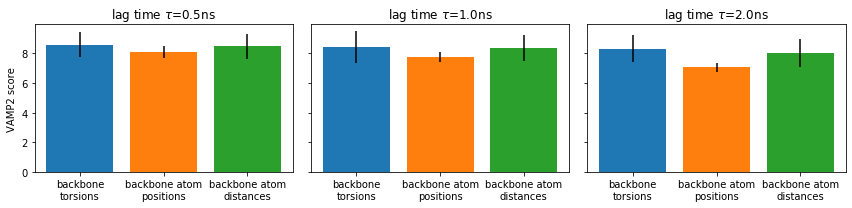

In [40]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')

fig.tight_layout()




Above we are comparing the different features at different lag times separately. It seems that backbone torsions and backbone atom distances are pretty high Vamp Score.

Doing more analysis on backbone torsions and backbone atom distances

In [55]:
torsions_data[0].shape

(49992, 56)

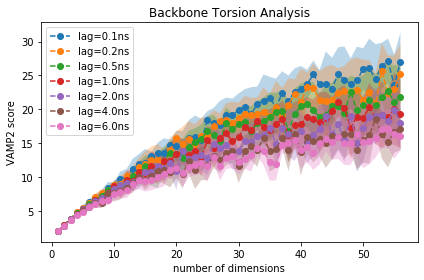

In [19]:
lags = [1, 2, 5, 10, 20, 40, 60]
dims = [i + 1 for i in range(56)]

fig = plt.figure()
##fig, ax = plt.subplots()
ax = fig.add_subplot()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(torsions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
ax.set_title('Backbone Torsion Analysis')
fig.tight_layout()


Backbone distance analysis

In [54]:
distances_data[0].shape

(49992, 945)

KeyboardInterrupt: 

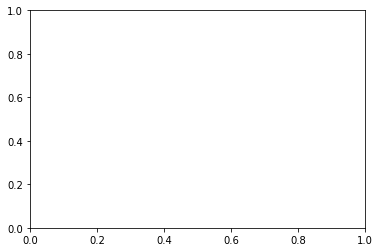

In [39]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(945)]

fig = plt.figure()
##fig, ax = plt.subplots()
ax = fig.add_subplot()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(distances_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
ax.set_title('Backbone Distances Analysis')
fig.tight_layout()


## TICA
Time Lagged Independent Component Analysis

The goal of the next step is to find a function that maps the usually high-dimensional input space into some lower-dimensional space that captures the important dynamics

In [35]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output) ##used for visualization purposes
tica_concatenated.shape


(199968, 38)

We perform TICA (with kinetic map scaling) using the lag time obtained from the VAMP-2 score

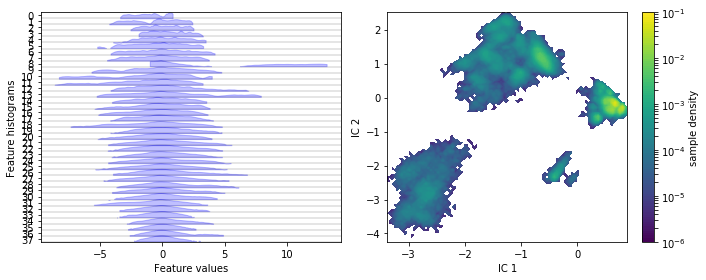

In [36]:
"""The object tica contains all the information about the specific transformation
        for larger systems, they recommend to pass the tica object itself into subsequent stages, e.g. clustering.
        for smaller systems the tica.get_outplut allows us to access the transformed data


"""
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output) ##used for visualization purposes

fig, axes = plt.subplots(1,2, figsize = (10,4))
"""Plotting the histograms for each TICA component"""
pyemma.plots.plot_feature_histograms(
    tica_concatenated, 
    ax = axes[0],
    #feature_labels = ['IC1','IC2','IC3','IC4'],
    ylog = True
)

pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax= axes[1], logscale = True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()


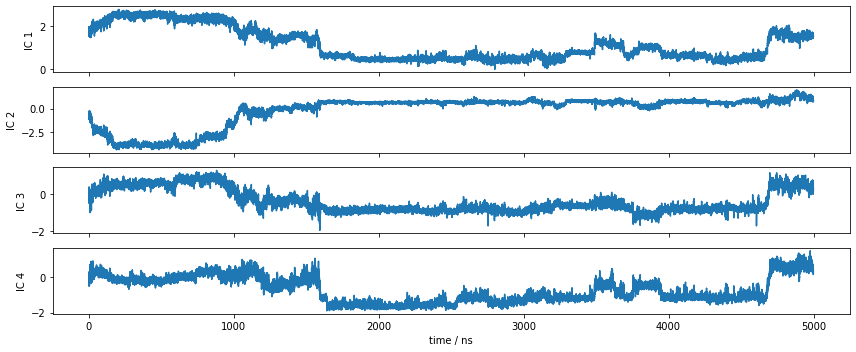

In [45]:

fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

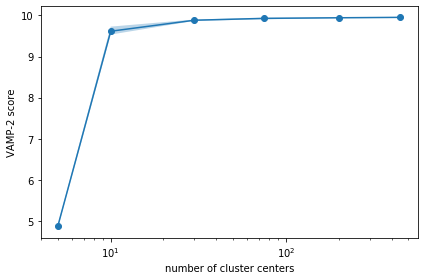

In [46]:

n_clustercenters = [5, 10, 30, 75, 200, 450]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

Backbone Distances TICA Analysis

RuntimeError: This function is only useful for less than 50 dimensions. Turn-off this warning at your own risk with ignore_dim_warning=True.

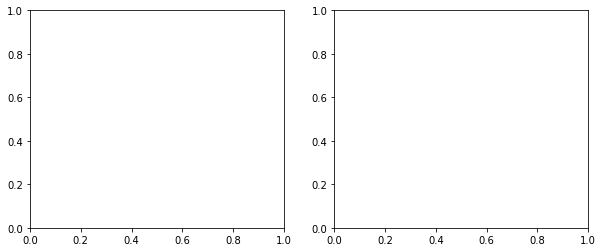

In [44]:
tica = pyemma.coordinates.tica(distances_data, lag=100)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output) ##used for visualization purposes

fig, axes = plt.subplots(1,2, figsize = (10,4))
"""Plotting the histograms for each TICA component"""
pyemma.plots.plot_feature_histograms(
    tica_concatenated, 
    ax = axes[0],
    #feature_labels = ['IC1','IC2','IC3','IC4'],
    ylog = True
)

pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax= axes[1], logscale = True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()


Getting Phi Psi angles. Note: cossin= False prevents taking cosine and sine angles of the phi/psi angles

In [5]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=False, periodic=False)
angles = pyemma.coordinates.load(files, features=torsions_feat)


Creates a csv file for each simulation 0 indicates simulation 1

In [ ]:
np.savetxt("name.csv", angles[0], delimiter = ",")
del name['columnname']